In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyarrow.parquet as pq   # For reading train_parquet file
import os
import numba 
from scipy.signal import find_peaks, argrelmax
import random
from tqdm.notebook import tqdm

In [2]:
data_folder = '../../input'
os.listdir(data_folder)

['metadata_train.csv', 'train.parquet', 'VSB Power Line Fault Detection']

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
df_meta = pd.read_csv(data_folder + '/metadata_train.csv')

In [5]:
%%time
# Load Parquet file containing 800k signal measurements for each signal_id in df_meta

parq_data = pq.read_pandas(data_folder + '/train.parquet').to_pandas()

Wall time: 14.3 s


## Understanding Data
* **Information on meta_data and signal_data**
* **Interpretation of data distribution**
* **Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals**  
* **Review peaks in sample signals**


### Information on meta_data and signal_data

In [6]:
df_meta.describe()

,signal_id,id_measurement,phase,target
count,8712.000000,8712.000000,8712.000000,8712.000000
mean,4355.500000,1451.500000,1.000000,0.060262
std,2515.082106,838.360658,0.816543,0.237985
min,0.000000,0.000000,0.000000,0.000000
25%,2177.750000,725.750000,0.000000,0.000000
50%,4355.500000,1451.500000,1.000000,0.000000
75%,6533.250000,2177.250000,2.000000,0.000000
max,8711.000000,2903.000000,2.000000,1.000000


In [7]:
df_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [8]:
parq_data.shape

(800000, 8712)

In [9]:
col = [str(i) for i in range(5)]
parq_data[col].head()

,0,1,2,3,4
0,18,1,-19,-16,-5
1,18,0,-19,-17,-6
2,17,-1,-20,-17,-6
3,18,1,-19,-16,-5
4,18,0,-19,-16,-5


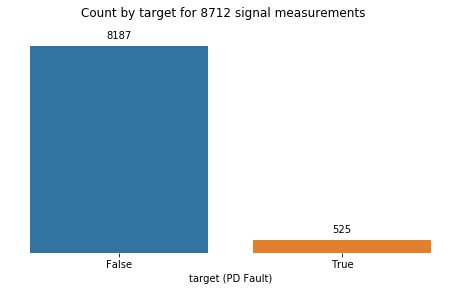

In [10]:
target = df_meta.target.copy()
plt.figure(figsize=(8, 4))
splot = sns.countplot(target.astype(bool))
for p in splot.patches:
    splot.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

splot.spines['top'].set_visible(False)
splot.spines['right'].set_visible(False)
splot.spines['left'].set_visible(False)
splot.spines['bottom'].set_visible(False)
splot.set(yticks=[])
plt.ylabel(None)
plt.xlabel('target (PD Fault)')
plt.suptitle(f'Count by target for {len(target)} signal measurements')
plt.show()

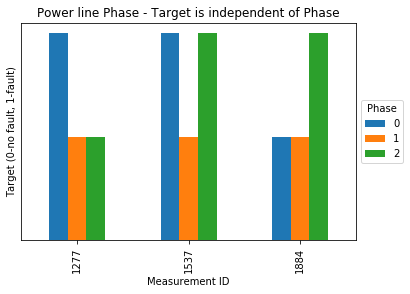

In [11]:
mids = [1277, 1537, 1884]
sample = df_meta.loc[df_meta.id_measurement.isin(mids), ["id_measurement", "phase", "target"]].copy()
sample.target = sample.target + 1
ax = sample.pivot("id_measurement", "phase", "target").plot(kind='bar')
ax.set(ylabel = 'Target (0-no fault, 1-fault)', 
       xlabel = 'Measurement ID', title = 'Power line Phase - Target is independent of Phase', 
       yticks=[])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Phase")
plt.show()

In [12]:
df_meta.corr()

,signal_id,id_measurement,phase,target
signal_id,1.000000,1.000000,0.000325,-0.023992
id_measurement,1.000000,1.000000,0.000000,-0.023993
phase,0.000325,0.000000,1.000000,0.001772
target,-0.023992,-0.023993,0.001772,1.000000


### Interpretation of data 
Understanding from above set of information
* Signal data (parq_data) contains 3 phase signal measurements.
* Each signal_id has 800k measurements in parq_data.
* parq_data has 3 phase (0, 1, 2) signal measurements for each of id_measurement. 
* Above table and phase plot highlights that target (1- PD fault or 0- PD free) is independent of phase and id_measurement

In [13]:
# Fault and Fault free signal_ids for understanding of signal patterns

fault_sid = df_meta.loc[df_meta.target == 1, 'signal_id']
fault_free_sid = df_meta.loc[df_meta.target == 0, 'signal_id']
print(fault_sid.shape, fault_free_sid.shape)

(525,) (8187,)


In [14]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    Source : https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [15]:
@numba.jit
def get_peaks_troughs(flat_signal, prominence=8, distance=51):
    """
    Return peaks and troughs of given flat_signals
    """
    (pks_idx, _) = find_peaks(flat_signal, prominence=prominence, distance=distance)
    (trough_idx, trough_p)  = find_peaks(flat_signal * -1, prominence=prominence, distance=distance)
    return pks_idx, trough_idx 


# 3 - Fast Fourier Transform denoising

#### A little bit of maths ...
The Fourier Transform of an 1D signal $x$ of length $n$ is the following : 

> ### $\mathscr{f}_j = \sum_{k=0}^{n-1} x_k e^{\frac{2\pi i}{n} jk} , ~~\forall j=0, ... , n-1$ 

The idea is to represent the signal in the complex space, It is roughly a sum of sinusoïdal functions. And there is one coefficient per frequency present in the signal.

The frequency takes the following values : 
- $f = \frac{1}{dn} [0, 1, \ldots ,   \frac{n}{2}-1,  -\frac{n}{2}, \ldots , -1] $  if $n$ is even
- $f =\frac{1}{dn}  [0, 1, \ldots,  \frac{n-1}{2}, -\frac{n-1}{2}, \ldots, -1] $   if $n$ is odd

#### Denoising algorithm
The denoising steps are the following :
- Apply the fft to the signal
- Compute the frequencies associated with each coefficient
- Keep only the coefficients which have a low enough frequency (in absolute)
- Compute the inverse fft

In [16]:
# Source : https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
@numba.jit 
def filter_signal(signal, threshold=1e8):
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return np.fft.irfft(fourier)

In [17]:
def plot_signals_n_peaks(sample, pks_idx, trough_idx, sub_plot_title=None, title=None, color='c'):
    """
    To plot sample signals and its peaks & troughs
    Sample                      : list of Sample signals measurements - 2D list
    pks_idx                     : peaks index list
    trough_idx                  : trough index list
    sub_plot_title              : list of title for for the sub plots
    title                       : Title of the plot
    """
    sz = len(sample)
    fig, axs = plt.subplots(sz,1, figsize=(12,sz*4))
    for i, ax in enumerate(axs) :
        ax.plot(sample[i], color=color, alpha=0.7)
        ax.scatter(pks_idx[i], sample[i][pks_idx[i]], color='red')
        ax.scatter(trough_idx[i], sample[i][trough_idx[i]], color='red')
        ax.set_title(sub_plot_title[i], fontsize=16)

    fig.suptitle(title, size=20, y=0.9)
    plt.show()

### Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals & Review peaks in sample signals

In [18]:
# Identify 3 sample signals measurements for plotting to understand patterns
# Flattern and find peaks of the sample (PD) Fault FREE signal measurements

sids = fault_free_sid.sample(2,random_state=55)   # Get random sample (PD)fault free signal_ids of measurements
sample_df = parq_data[map(str, sids)]             # assign measurement data of the samples

prominence, distance, cols = 6, 100, sample_df.columns     # Set values for flatten and find_peaks of signals 
sample, flat_sample, pks_idx, trough_idx = [], [], [], []  # initialize lists for flatten and peaks signals
denoised_sample, d_flat_sample = [], []
d_pks_idx, d_trough_idx = [], []

for i, col in enumerate(cols):
    sample.append(sample_df[col].values)
    flat_sample.append(flatiron(sample[i].astype(np.float)))
    p_idx, t_idx = get_peaks_troughs(flat_sample[i])
    pks_idx.append(p_idx)
    trough_idx.append(t_idx)
    
    denoised_sample.append(filter_signal(sample[i], threshold=1.37e7))
    d_flat_sample.append(flatiron(denoised_sample[i].astype(np.float)))
    p_idx, t_idx = get_peaks_troughs(d_flat_sample[i])
    d_pks_idx.append(p_idx)
    d_trough_idx.append(t_idx)


<ipython-input-15-7f5c90594701>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_peaks_troughs" failed type inference due to: Untyped global name 'find_peaks': cannot determine Numba type of <class 'function'>

File "<ipython-input-15-7f5c90594701>", line 6:
def get_peaks_troughs(flat_signal, prominence=8, distance=51):
    <source elided>
    """
    (pks_idx, _) = find_peaks(flat_signal, prominence=prominence, distance=distance)
    ^

  @numba.jit
C:\Users\Mukund\.conda\envs\issmCA3VSB\lib\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "get_peaks_troughs" was compiled in object mode without forceobj=True.

File "<ipython-input-15-7f5c90594701>", line 2:
@numba.jit
def get_peaks_troughs(flat_signal, prominence=8, distance=51):
^

  state.func_ir.loc))
C:\Users\Mukund\.conda\envs\issmCA3VSB\lib\site-packages\numba\object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilatio

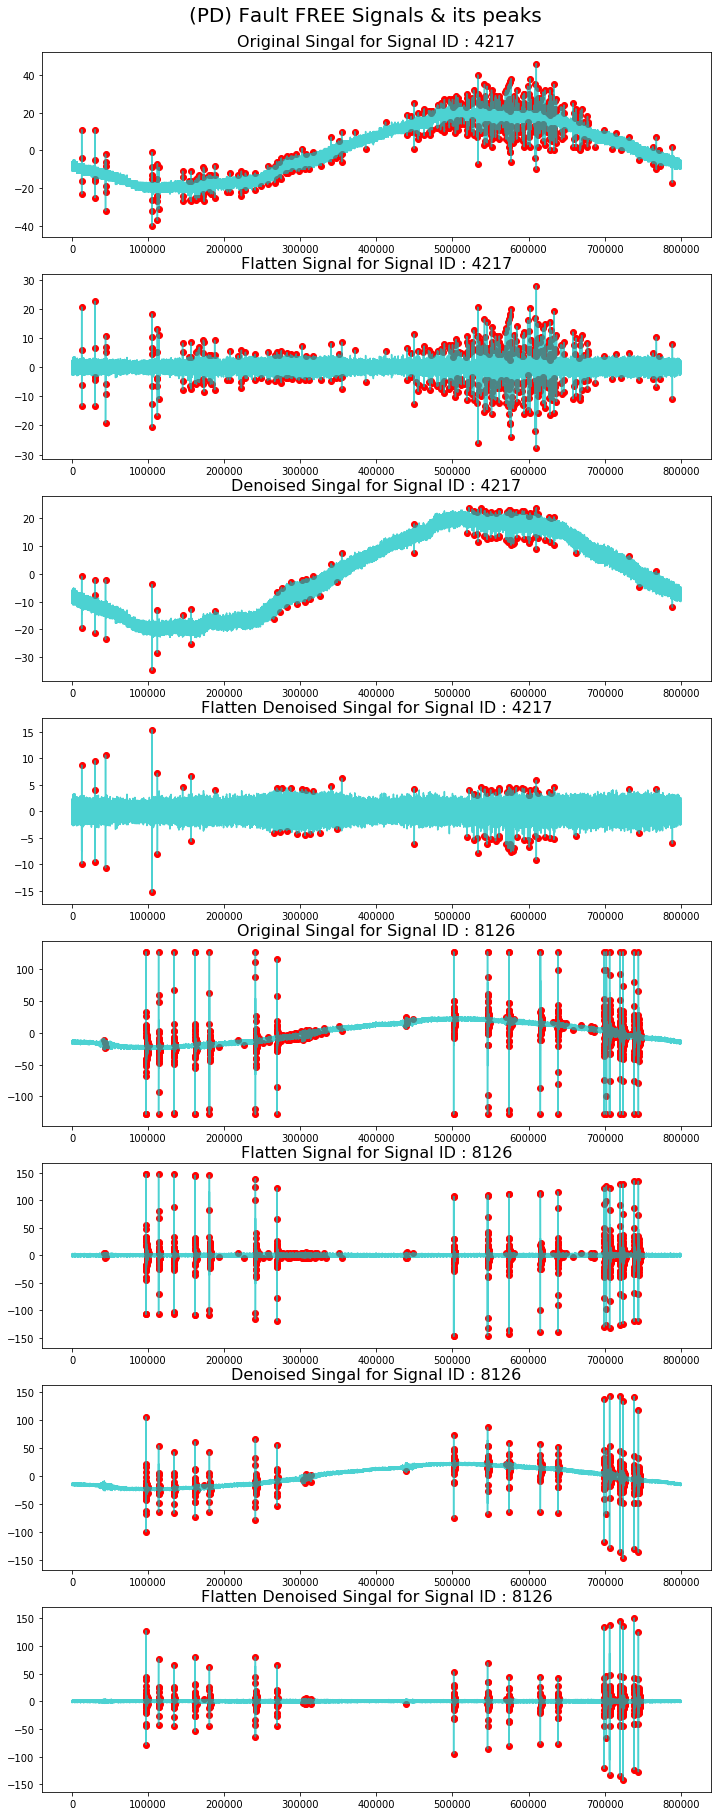

In [19]:
# Plot PD Fault FREE sample signals

t1 = ['Original Singal for Signal ID : ' + str(sid) for sid in sids]
t2 = ['Flatten Signal for Signal ID : ' + str(sid) for sid in sids]
t3 = ['Denoised Singal for Signal ID : ' + str(sid) for sid in sids]
t4 = ['Flatten Denoised Singal for Signal ID : ' + str(sid) for sid in sids]

sub_plot_title = [item for sublist in zip(t1,t2, t3, t4) for item in sublist]

c_sample = [item for sublist in zip(sample, flat_sample, denoised_sample, d_flat_sample) for item in sublist]
c_pks_idx = [item for sublist in zip(pks_idx, pks_idx, d_pks_idx, d_pks_idx) for item in sublist]
c_trough_idx = [item for sublist in zip(trough_idx, trough_idx, d_trough_idx, d_trough_idx) for item in sublist]

plot_signals_n_peaks(c_sample, c_pks_idx, c_trough_idx, sub_plot_title, '(PD) Fault FREE Signals & its peaks')

In [20]:
# Identify 3 sample signals measurements for plotting to understanding patterns
# Flattern and find peaks of the sample (PD) FAULT signal measurements

sids = fault_sid.sample(2,random_state=55) # Get random sample (PD)fault signal_ids of measurements
sample_df = parq_data[map(str, sids)]             # assign measurement data of the samples

prominence, distance, cols = 6, 100, sample_df.columns     # Set values for flatten and find_peaks of signals 
sample, flat_sample, pks_idx, trough_idx = [], [], [], []  # initialize lists for flatten and peaks signals
denoised_sample, d_flat_sample = [], []
d_pks_idx, d_trough_idx = [], []

for i, col in enumerate(cols):
    sample.append(sample_df[col].values)
    flat_sample.append(flatiron(sample[i].astype(np.float)))
    p_idx, t_idx = get_peaks_troughs(flat_sample[i])
    pks_idx.append(p_idx)
    trough_idx.append(t_idx)
    
    denoised_sample.append(filter_signal(sample[i], threshold=1.37e7))
    d_flat_sample.append(flatiron(denoised_sample[i].astype(np.float)))
    p_idx, t_idx = get_peaks_troughs(d_flat_sample[i])
    d_pks_idx.append(p_idx)
    d_trough_idx.append(t_idx)


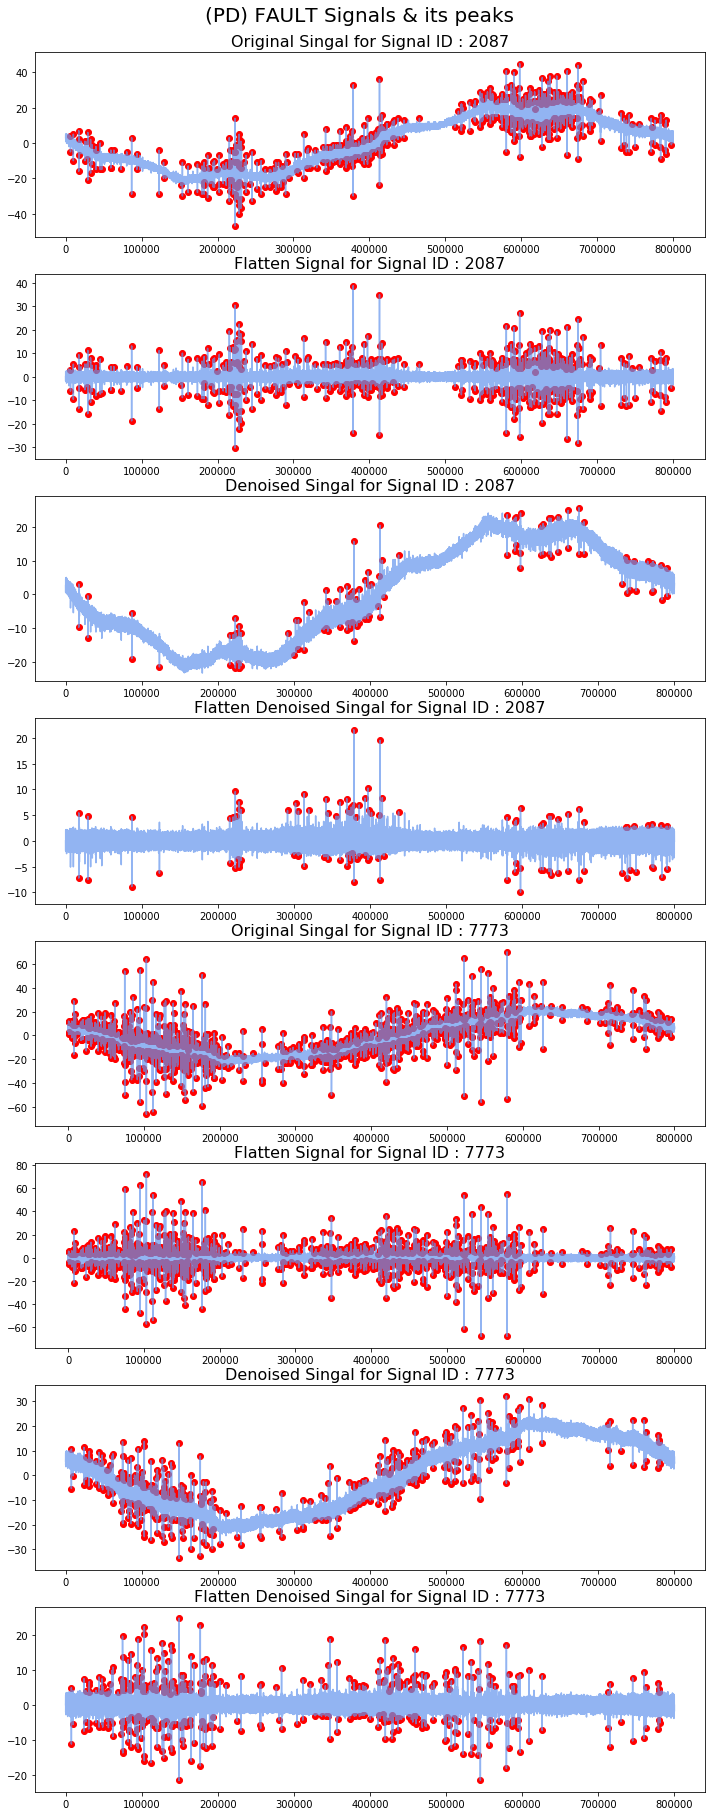

In [21]:
# Plot PD Fault sample signals

t1 = ['Original Singal for Signal ID : ' + str(sid) for sid in sids]
t2 = ['Flatten Signal for Signal ID : ' + str(sid) for sid in sids]
t3 = ['Denoised Singal for Signal ID : ' + str(sid) for sid in sids]
t4 = ['Flatten Denoised Singal for Signal ID : ' + str(sid) for sid in sids]

sub_plot_title = [item for sublist in zip(t1,t2, t3, t4) for item in sublist]

c_sample = [item for sublist in zip(sample, flat_sample, denoised_sample, d_flat_sample) for item in sublist]
c_pks_idx = [item for sublist in zip(pks_idx, pks_idx, d_pks_idx, d_pks_idx) for item in sublist]
c_trough_idx = [item for sublist in zip(trough_idx, trough_idx, d_trough_idx, d_trough_idx) for item in sublist]

plot_signals_n_peaks(c_sample, c_pks_idx, c_trough_idx, sub_plot_title, '(PD) FAULT Signals & its peaks', color='cornflowerblue')

In [49]:
@numba.jit(parallel=True)
def calculate_statistical_features (signal):
    """
    Find statistical features - mean, median, standard deviation, rms, n5, n25, n95
    for given denoised flatten signal
    """
    mean = np.nanmean(signal)
    median = np.nanpercentile(signal, 50)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    n5 = np.nanpercentile(signal, 5)
    n25 = np.nanpercentile(signal, 25)
    n75 = np.nanpercentile(signal, 75)
    n95 = np.nanpercentile(signal, 95)
        
    return [mean, median, std, rms, n5, n25, n95]

In [50]:
%xmode 

Exception reporting mode: Minimal


In [51]:
@numba.jit(nopython=True)
def clip(v, l, u):
    """Numba helper function to clip a value"""
    
    if v < l:
        v = l
    elif v > u:
        v = u
        
    return v

@numba.jit(nopython=True)
def create_sawtooth_template(sawtooth_length, pre_length, post_length):
    """Generate sawtooth template"""
    
    l = pre_length+post_length+1
    
    st = np.zeros(l)
    for i in range(sawtooth_length+1):
        
        j = pre_length+i
        if j < l:
            st[j] = 1 - ((2./sawtooth_length) * i)
        
    return st

@numba.jit(nopython=True)
def calculate_peak_features(pks_idx, x_signal0, window_small=5, window_large=25):
    """
    Calculate features for peaks.
    Parameters
    ----------
    pks_idx : ndarray
        Indices of peaks.
    x_signal0 : ndarray
        The array to search.
    window_small : np.int
        How many points on each side to use for small window features
    window_large : np.int
        How many points on each side to use for large window features
    Returns
    -------
    features : ndarray
        Features calculate for each peak in `x_signal0`.
    """
    
    peak_features_names = [
    'ratio_next',
    'ratio_prev',
    'small_dist_to_min',
    'sawtooth_rmse',
    ] 
    
    num_peak_features = len(peak_features_names)

    features = np.ones((pks_idx.shape[0], num_peak_features), dtype=np.float64) * np.nan
    
    for i in range(pks_idx.shape[0]):
        
        feature_number = 0
        
        x = pks_idx[i]
        x_next = x+1
        x_prev = x-1
        
        signal0 = x_signal0[x]

        window_small_start = clip(x-window_small, 0, 800000-1)
        window_small_end = clip(x+window_small, 0, 800000-1)
        window_large_start = clip(x-window_large, 0, 800000-1)
        window_large_end = clip(x+window_large, 0, 800000-1)
        
        window_small_pre = x - window_small_start
        window_small_post = window_small_end - x
        
        window_large_pre = x - window_large_start
        window_large_post = window_large_end - x
            
        if x_next < 800000:
            signal0_next = x_signal0[x_next]
            features[i, feature_number] = np.abs(signal0_next)/np.abs(signal0)
        feature_number += 1
            
        if x_prev >= 0:
            signal0_prev = x_signal0[x_prev]
            features[i, feature_number] = np.abs(signal0_prev)/np.abs(signal0)
        feature_number += 1
            
        x_hp_window_small0 = x_signal0[window_small_start:window_small_end+1]
        x_hp_window_large0 = x_signal0[window_large_start:window_large_end+1]
        x_hp_window_large0_norm = (x_hp_window_large0/np.abs(signal0))
        x_hp_window_small0_norm = (x_hp_window_small0/np.abs(signal0))
        x_hp_abs_window_large0 = np.abs(x_hp_window_large0)
        window_large_max_0 = np.max(x_hp_abs_window_large0)
        
        window_small_opp_peak_i = np.argmin(x_hp_window_small0*np.sign(signal0))
        
        features[i, feature_number] = window_small_opp_peak_i - window_small
        feature_number += 1
        
        x_hp_window_large0_norm_sign = x_hp_window_large0_norm * np.sign(signal0)
            
        sawtooth_length = 3
        saw_tooth_template = create_sawtooth_template(sawtooth_length, window_large_pre, window_large_post)
        
        """
        print ('st ', i,  st, x_hp_window_large0_norm_sign)
        print ('np.argmax(st) ', np.argmax(st))
        print ('np.argmax(x_hp_window_large0_norm_sign) ', np.argmax(x_hp_window_large0_norm_sign))
        """
        
        # assert np.argmax(st) == np.argmax(x_hp_window_large0_norm_sign)  #==> Check this as multiple peaks found in window
        
        assert saw_tooth_template.shape[0] == x_hp_window_large0_norm_sign.shape[0]
        features[i, feature_number] = np.mean(np.power(x_hp_window_large0_norm_sign - saw_tooth_template, 2))
        feature_number += 1
        
        if i == 0:
            assert feature_number == num_peak_features
        
    return features, peak_features_names

In [52]:
# @numba.jit(parallel=True)
def find_features(signal, signal_ids) :
    """
    Determine Features for the given denoised flat signal.
    Input :
        signal  :  Denoised flatten Signal
        signal_ids     :  Signal IDs of given given signal
    Returns :
        peaks_n_features : Returns a list containing features (including peaks, hiehgts and statistical features) 
                           determined for the given signal and combine it with signal_id
                           Returns a list for a shape of (signal.shape[0], flatten peaks_n_features)
        feature_names    : Feature column names corresponding to peaks_n_features    
    """
    length = len(signal)
    print(f'Processing for {length} signal measurements')
    features = np.ones((length, 7), dtype=np.float64) * np.nan  # 7 features
    pks_n_features = []
    
    feature_names = [
        'peaks_idx',
        'heights',
        'mean',
        'median',
        'std',
        'rms',
        'n5',
        'n25',
        'n95',
        'signal_id',
    ]
    denoise_threshold = 1.37e7

    for i in tqdm(numba.prange(length), desc='Finding Features:') : 

        denoised_signal = filter_signal(signal[i], threshold=denoise_threshold)
        flat_signal = flatiron(denoised_signal.astype(np.float))    # ==> flatten first before denoise
    
        # Get features : peaks indices (combined peaks+troughs) and their absolute heights
        pks_idx, troughs_idx = get_peaks_troughs(flat_signal)  #==> check this abs signal
        
        """
        print('pks_idx ', pks_idx)
        print('troughs_idx ', troughs_idx)
        """
        
        peaks_idx = np.concatenate((pks_idx, troughs_idx)).T  
        idx = np.argsort(peaks_idx)
        peaks_idx = peaks_idx[idx]
        heights = np.abs(flat_signal)[peaks_idx]
        
        stats_features = np.ones((peaks_idx.shape[0], 8), dtype=np.float64) * np.nan
        mean, median, std, rms, n5, n25, n95 = calculate_statistical_features(flat_signal) 
        stats_features[:, 0] = mean
        stats_features[:, 1] = median
        stats_features[:, 2] = std
        stats_features[:, 3] = rms
        stats_features[:, 4] = n5
        stats_features[:, 5] = n25
        stats_features[:, 6] = n95
        stats_features[:, 7] = signal_ids[i]
        
        peaks_features, peak_features_names = calculate_peak_features(
            peaks_idx,
            flat_signal
        )
        
        # print('calculate_peak_features returned')
        
        pks_n_features.append(np.hstack([
            peaks_idx[:, np.newaxis],
            heights[:, np.newaxis],
            stats_features,
            peaks_features,
        ]))
    
    return pks_n_features, feature_names + peak_features_names


In [55]:
%%time

peaks_n_features, feature_names = find_features(parq_data.values.T[:200], df_meta.signal_id[:200].values)

peaks_n_features = np.concatenate(peaks_n_features) # flatten before converting to pd.dataframe

features = pd.DataFrame(peaks_n_features, columns=feature_names)

features.head()

Processing for 200 signal measurements



Wall time: 1min 13s


,peaks_idx,heights,mean,median,std,rms,n5,n25,n95,signal_id,ratio_next,ratio_prev,small_dist_to_min,sawtooth_rmse
0,265722.0,6.022652,0.000038,-0.001432,0.658799,0.508522,-1.057893,-0.417737,1.059766,0.0,0.996308,0.031937,5.0,0.059977
1,268512.0,4.035156,0.000038,-0.001432,0.658799,0.508522,-1.057893,-0.417737,1.059766,0.0,0.451643,0.476620,5.0,0.111463
2,275734.0,6.833604,0.000038,-0.001432,0.658799,0.508522,-1.057893,-0.417737,1.059766,0.0,0.979394,0.169611,5.0,0.063520
3,275742.0,4.079969,0.000038,-0.001432,0.658799,0.508522,-1.057893,-0.417737,1.059766,0.0,0.646045,0.639391,5.0,0.193648
4,286673.0,5.704696,0.000038,-0.001432,0.658799,0.508522,-1.057893,-0.417737,1.059766,0.0,0.701559,0.042544,5.0,0.071341


In [54]:
features.tail()

,peaks_idx,heights,mean,median,std,rms,n5,n25,n95,signal_id,ratio_next,ratio_prev,small_dist_to_min,sawtooth_rmse
39135,713518.0,4.571952,-0.000342,-0.001252,1.137698,0.91222,-1.875146,-0.776547,1.876418,99.0,0.625120,0.765215,-2.0,0.229141
39136,717491.0,3.837952,-0.000342,-0.001252,1.137698,0.91222,-1.875146,-0.776547,1.876418,99.0,0.730369,0.582909,-5.0,0.242779
39137,724736.0,4.289260,-0.000342,-0.001252,1.137698,0.91222,-1.875146,-0.776547,1.876418,99.0,0.649587,0.856708,5.0,0.243756
39138,781348.0,4.199821,-0.000342,-0.001252,1.137698,0.91222,-1.875146,-0.776547,1.876418,99.0,0.980935,0.655486,-5.0,0.295293
39139,793521.0,4.195526,-0.000342,-0.001252,1.137698,0.91222,-1.875146,-0.776547,1.876418,99.0,0.692516,0.756452,2.0,0.198963
